In [1]:
import numpy as np 
import pandas as pd 
import os
import re
import matplotlib.pyplot as plt
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from tensorflow import keras


2022-02-15 18:14:56.354160: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-15 18:14:56.354184: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:


data_1 = pd.read_json("Sarcasm_Headlines_Dataset.json", lines=True)
data_2 = pd.read_json("Sarcasm_Headlines_Dataset_v2.json", lines=True)
data =  pd.concat([data_1, data_2])
#data.head()



In [3]:
def clean_text(text):
    text = text.lower()
    
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = pattern.sub('', text)
    text = " ".join(filter(lambda x:x[0]!='@', text.split()))
    emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    text = emoji.sub(r'', text)
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)        
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text) 
    text = re.sub(r"\'ll", " will", text)  
    text = re.sub(r"\'ve", " have", text)  
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"have't", "have not", text)
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    return text

In [4]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def CleanTokenize(df):
    head_lines = list()
    lines = df["headline"].values.tolist()

    for line in lines:
        line = clean_text(line)
        # tokenize the text
        tokens = word_tokenize(line)
        # remove puntuations
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # remove non alphabetic characters
        words = [word for word in stripped if word.isalpha()]
        stop_words = set(stopwords.words("english"))
        # remove stop words
        words = [w for w in words if not w in stop_words]
        head_lines.append(words)
    return head_lines

head_lines = CleanTokenize(data)
#head_lines[0:10]

In [5]:
validation_split = 0.2
max_length = 25


tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(head_lines)
sequences = tokenizer_obj.texts_to_sequences(head_lines)

word_index = tokenizer_obj.word_index
#print("unique tokens - ",len(word_index))
vocab_size = len(tokenizer_obj.word_index) + 1
#print('vocab size -', vocab_size)

lines_pad = pad_sequences(sequences, maxlen=max_length, padding='post')
sentiment =  data['is_sarcastic'].values

indices = np.arange(lines_pad.shape[0])
np.random.shuffle(indices)
lines_pad = lines_pad[indices]
sentiment = sentiment[indices]

num_validation_samples = int(validation_split * lines_pad.shape[0])

X_train_pad = lines_pad[:-num_validation_samples]
y_train = sentiment[:-num_validation_samples]
X_test_pad = lines_pad[-num_validation_samples:]
y_test = sentiment[-num_validation_samples:]

In [6]:
#print('Shape of X_train_pad:', X_train_pad.shape)
#print('Shape of y_train:', y_train.shape)

#print('Shape of X_test_pad:', X_test_pad.shape)
#print('Shape of y_test:', y_test.shape)

Shape of X_train_pad: (44263, 25)
Shape of y_train: (44263,)
Shape of X_test_pad: (11065, 25)
Shape of y_test: (11065,)


In [6]:
embeddings_index = {}
embedding_dim = 100
GLOVE_DIR = "Home/Project/glove.twitter.27B"
f = open(os.path.join( 'glove.twitter.27B.100d.txt'), encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

#print('Found %s word vectors.' % len(embeddings_index))

In [8]:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
c = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        c+=1
        embedding_matrix[i] = embedding_vector
#print(c)

In [9]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

In [11]:
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.25))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
#model = keras.models.load_model('Sarcastic_Detector/')

print(model.summary())

#print('Summary of the built model...')
#print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 100)           2865800   
                                                                 
 lstm_1 (LSTM)               (None, 64)                42240     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,908,105
Trainable params: 42,305
Non-trainable params: 2,865,800
_________________________________________________________________
None


In [12]:
history = model.fit(X_train_pad, y_train, batch_size=32, epochs=25, validation_data=(X_test_pad,y_test)
                   ,verbose=2)

Epoch 1/25


2022-02-15 18:16:28.303347: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 11463200 exceeds 10% of free system memory.


1384/1384 - 25s - loss: 0.5059 - acc: 0.7522 - val_loss: 0.4279 - val_acc: 0.8049 - 25s/epoch - 18ms/step
Epoch 2/25
1384/1384 - 23s - loss: 0.4212 - acc: 0.8060 - val_loss: 0.3958 - val_acc: 0.8275 - 23s/epoch - 16ms/step
Epoch 3/25
1384/1384 - 25s - loss: 0.3821 - acc: 0.8286 - val_loss: 0.3852 - val_acc: 0.8268 - 25s/epoch - 18ms/step
Epoch 4/25
1384/1384 - 23s - loss: 0.3564 - acc: 0.8439 - val_loss: 0.3437 - val_acc: 0.8511 - 23s/epoch - 17ms/step
Epoch 5/25
1384/1384 - 23s - loss: 0.3349 - acc: 0.8527 - val_loss: 0.3403 - val_acc: 0.8515 - 23s/epoch - 17ms/step
Epoch 6/25
1384/1384 - 23s - loss: 0.3200 - acc: 0.8600 - val_loss: 0.3234 - val_acc: 0.8635 - 23s/epoch - 17ms/step
Epoch 7/25
1384/1384 - 23s - loss: 0.2996 - acc: 0.8724 - val_loss: 0.3165 - val_acc: 0.8663 - 23s/epoch - 17ms/step
Epoch 8/25
1384/1384 - 23s - loss: 0.2859 - acc: 0.8784 - val_loss: 0.3005 - val_acc: 0.8753 - 23s/epoch - 17ms/step
Epoch 9/25
1384/1384 - 23s - loss: 0.2732 - acc: 0.8847 - val_loss: 0.2916 

In [13]:

model.save('Sarcastic_Detector/')

2022-02-15 18:37:06.893866: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: Sarcastic_Detector/assets


2022-02-15 18:37:08.363797: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 11463200 exceeds 10% of free system memory.


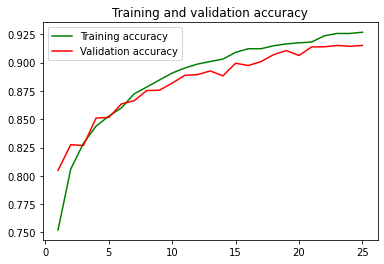

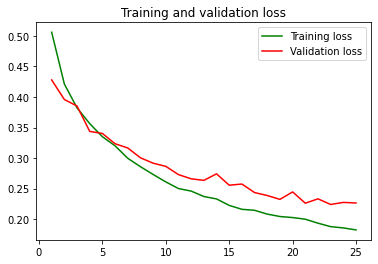

In [14]:
#Plot results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [64]:
class Sarcasm:
    def predict_sarcasm(s):
        x_final = pd.DataFrame({"headline":[s]})
        test_lines = CleanTokenize(x_final)
        test_sequences = tokenizer_obj.texts_to_sequences(test_lines)
        
        test_review_pad = pad_sequences(test_sequences, maxlen=max_length, padding='post')
        pred = model.predict(test_review_pad)
        pred*=100
        if pred[0][0]>=50: return "It's a sarcasm!"  
        else: return "It's not a sarcasm."
    

In [68]:
Sarcasm.predict_sarcasm("i was sad. he told me to smile. it worked im not sad anymore")

"It's a sarcasm!"